<h1>Day-2</h1>
<h2>Advanced Path Integral Methods in a Simulation of Water Across its Phase Diagram</h2>
<h3>Michele Ceriotti</h3>


In this set of exercises we will perform simulations of room-temperature liquid water, using a simple empirical forcefield model based on TIP4P-like point charges [1]. We will start from quickly checking the convergence of standard path integral molecular dynamics, and then use this example to test a number of advanced PI features. For the sake of speed of execution, we will use a very small (32 molecules) simulation box. However, if you have more time to carry out the exercise, you can modify the input to use the initial configurations in `data/water-216.pdb` . You should be able to complete at least the first three exercises in a couple of hours. 
Hints: Do not wait for the full simulations to be complete: as soon as you have collected enough statistics to understand what’s going on and to compare with previous runs, you should move on to the next exercise.

In [2]:
import argparse
import itertools
import sys
import csv
import os
import numpy as np
from ipi.utils.io import read_file_raw
from ipi.utils.units import unit_to_internal, unit_to_user
from ipi.utils.messages import verbosity
from matplotlib import pyplot as plt
from autocorr import autoCorr
from getRDF import RDF

<h2>Exercise 1 - A PIMD simulation of liquid water</h2>

1. Look at the i-PI input file in `ex-1/base.xml` . Observe the properties and trajectory files that are specified in the <output></output> section. Make sure it is clear what each part of the input does. For this example we will use the PILE-G thermostat[2] and constant-temperature sampling. We will initially perform a reference molecular dynamics run, with $P=1$ .

    `$ cd ex-1` <br>
    `$ i-pi base.xml &> log.ipi &` <br>
    `$ lmp_serial < in.water &> log.lammps &`


2. Modify the input so that you’ll run with $P = 6$ beads, by changing the nbeads option of the ```<initialize>``` field. It is advisable to make these changes on a copy of the `ex-1/base.xml` input file. You may also want to adjust prefix so that it indicates the new number of beads (e.g. `prefix="base_p-6"` ). Repeat with $P = 32$. 

   Hints: Simulations may take some time to complete so you might want to launch all of them and continue with the following exercises. In order to run multiple i-PI simulations simultaneously you should also change the name of the UNIX-domain socket – that is the ```<address>``` field in the input of i-PI, and the corresponding label in the fix_ipi command in the input of LAMMPS.


3. Analyze the outcomes of the simulations and check for convergence. You can quickly compute averages for thermodynamic quantities from the command line using the autocorr code, e.g. for the potential energy. 

	Hints: The function `autoCorr` defined here, below will also compute error estimates that take into account the autocorrelation time for the observable. With short trajectories, this tends to be significantly under-estimated. Note also that we are discarding a short part of the trajectory for equilibration (~43 fs) - in a production calculation you should carefully check equilibration and discard a part of the trajectory accordingly.

In [2]:
#column1  timesteps 
#column2  time picosecond
#column3  conserved energy
#column4  temperature /K
#column5  kinetic_cv (centroid-virial quantum kinetic energy)
#column6  potential (potential energy)

print('=================================== kinetic ============================================')
mean,error = autoCorr('ex-1/base_p-1.out', nbead=1, columns=[4], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=6)

mean,error = autoCorr('ex-1/base_p-6.out', nbead=6, columns=[4], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=6)

trad_kin_mean,trad_kin_error = autoCorr('ex-1/base_p-32.out', nbead=32, columns=[4], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=6)

print('================================= potential ============================================')
mean,error = autoCorr('ex-1/base_p-1.out', nbead=1, columns=[5], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=6)

mean,error = autoCorr('ex-1/base_p-6.out', nbead=6, columns=[5], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=6)

trad_pot_mean,trad_pot_error = autoCorr('ex-1/base_p-32.out', nbead=32, columns=[5], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=6)


=================================== kinetic ============================================
================================== 1 bead =============================================
 mean = 1.3681e-01  |  variance: = -3.4694e-18  |  st.dev. = 0.0000e+00
<tau> = 9.9500e+01  |    <tau^2> = 9.9500e+01  |  error = 0.0000e+00

================================== 6 beads =============================================
 mean = 3.1524e-01  |  variance: = 1.1602e-04  |  st.dev. = 1.0771e-02
<tau> = 3.0369e+00  |    <tau^2> = 1.1752e+00  |  error = 5.3652e-04

================================== 32 beads =============================================
 mean = 4.2956e-01  |  variance: = 1.1277e-04  |  st.dev. = 1.0619e-02
<tau> = 1.7574e+00  |    <tau^2> = 8.9059e-01  |  error = 5.0782e-04

================================= potential ============================================
================================== 1 bead =============================================
 mean = -4.9315e-01  |  variance: = 2.6014e

4. Have a look at the trajectories with the VMD software Hints: You can launch VMD from the command line with e.g. 

    `$ vmd base_p-1.pos_0.pdb`
    
    You can load all of the ring polymer beads as separate molecules to visualize the spread of the ring polymer.

	`$ vmd -m base_p-32.pos_*.pdb`

	and you can also use some of the i-PI post-processing tools to visualize the connections within the ring polymer. Hints: Note that you have to load the file from the TCL prompt in VMD to disable automatic bond detection.
    
	`$ i-pi-mergebeadspdb base_p-32 > base_p-32_merged.pdb` <br>
	`$ vmd` <br>
	`vmd > mol new base_p-32_merged.pdb type pdb autobonds 0`

	You can see clearly the different spread of the ring polymers of H and O atoms.


5. Compute radial distribution functions for different simulations. You can use any tool of your liking, but we suggest `getRDF.py`. For instance, for one of the replicas in the 32-beads run,

    `$ python ../getRDF.py base_p-32 "pdb" O O 250 0. 5. 0.1`
	
	

 number of beads = 32,  Processing frame 100 

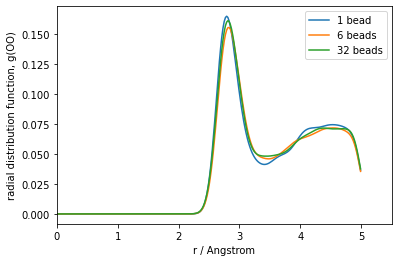

In [3]:
beads = np.array(['1','6','32'])
nbins = 250
rdf = np.zeros((len(beads),nbins))
dist = np.zeros((len(beads),nbins))
count = 0
fig,ax = plt.subplots()
wp = 5

for i in beads:
    os.chdir('ex-1')
    RDF('base_p-'+i, "pdb", 'O', 'O', 250, 0., 5., 0.1)
    os.chdir('../')
    infile = 'ex-1/base_p-'+i+'.OO.rdf.dat'
    rdf[count,:] = np.genfromtxt(infile,usecols = 1) 
    dist[count,:] = np.genfromtxt(infile,usecols = 0)
    plt.plot(dist[count,:],rdf[count,:],label=str(int(i))+' beads' if int(i)>1 else str(int(i))+' bead')
    count +=1

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads 
plt.xlabel('r / Angstrom')
plt.ylabel('radial distribution function, g(OO)')
ax.set_xlim([0.,5.5])
plt.legend(loc = 1)
plt.show()

Also compute the O–H radial distribution function.
    
```$ python ../getRDF.py base_p-32 "pdb" O H 300 0. 3. 0.1```


 number of beads = 32,  Processing frame 100 

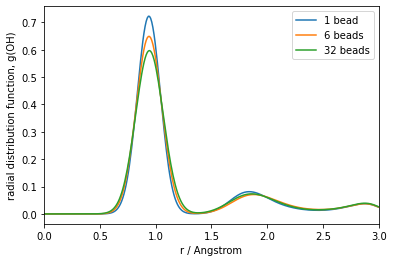

In [4]:
beads = np.array(['1','6','32'])
nbins = 300
rdf = np.zeros((len(beads),nbins))
dist = np.zeros((len(beads),nbins))
count = 0
fig,ax = plt.subplots()

for i in beads:
    os.chdir('ex-1')
    RDF('base_p-'+i, "pdb", 'O', 'H', 300, 0., 3., 0.1)
    os.chdir('../')
    infile = 'ex-1/base_p-'+i+'.OH.rdf.dat'
    rdf[count,:] = np.genfromtxt(infile,usecols = 1) 
    dist[count,:] = np.genfromtxt(infile,usecols = 0)
    plt.plot(dist[count,:],rdf[count,:],label=str(int(i))+' beads' if int(i)>1 else str(int(i))+' bead')
    count +=1

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads 
plt.xlabel('r / Angstrom')
plt.ylabel('radial distribution function, g(OH)')
ax.set_xlim([0.,3.])
plt.legend(loc = 1)
plt.show()

<h2>Exercise 2 - Colored-noise thermostatting </h2>

Move to the `ex-2/` folder. Here we will try to reduce the number of path integral replicas needed to converge a PIMD simulation by using a colored-noise thermostat, designed to selectively enhance fluctuations of high-frequency modes, so as to match the quantum predictions [3].

1. Look at the input file. The only significant difference relative to Exercise 1 is the change in the ```<thermostat>``` section. The matrix elements that are included in this section determine the behavior of the colored-noise dynamics, and have been fitted to give the correct quantum fluctuations in the harmonic limit. Parameters that are suitable for a broad range of conditions can be obtained from the on-line repository http://gle4md.org/index.html?page=matrix – familiarize yourself with the interface.


2. Run your simulation – the commands are pretty much the same as what you used in <strong>Exercise 1</strong>. Compute the mean quantum and kinetic energy, and compare them with the results you had from conventional PIMD.



=================================== kinetic ============================================
================================== 6 beads =============================================
 mean = 4.3192e-01  |  variance: = 3.3361e-04  |  st.dev. = 1.8265e-02
<tau> = 2.5504e+00  |    <tau^2> = 1.2178e+00  |  error = 1.0202e-03

================================= potential ============================================
================================== 6 beads =============================================
 mean = -1.8733e-01  |  variance: = 4.8000e-04  |  st.dev. = 2.1909e-02
<tau> = 8.5136e+00  |    <tau^2> = 2.2825e+00  |  error = 2.2358e-03



NameError: name 'trad_kin_mean' is not defined

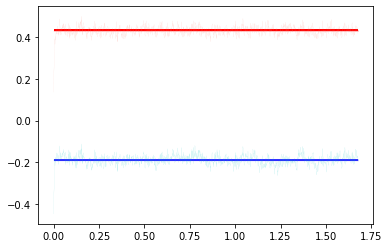

In [3]:
print('=================================== kinetic ============================================')
kinMean,kinError = autoCorr('ex-2/piglet_p-6.out', nbead=6, columns=[4], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=6)
print('================================= potential ============================================')
potMean,potError = autoCorr('ex-2/piglet_p-6.out', nbead=6, columns=[5], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=6)

data = np.genfromtxt('ex-2/piglet_p-6.out',usecols=[1,4,5])

plt.plot(data[:,0],data[:,2], 'c-', linewidth=0.05)
plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=potMean,color='b', label='PIGLET potential (6 beads)')
plt.fill_between(data[:,0], potMean-potError, potMean+potError, color='b', alpha=0.2 )

plt.plot(data[:,0],data[:,1], '-', color='salmon', linewidth=0.05)
plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=kinMean,color='r', label='PIGLET kinetic (6 beads)', linewidth=2.)
plt.fill_between(data[:,0], kinMean-kinError, kinMean+kinError, color='r', alpha=0.2 )

plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=trad_kin_mean,color='y', label='conventional PIMD kinetic (32 beads)', linewidth=2.)
plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=trad_pot_mean,color='g', label='conventional PIMD potential (32 beads)', linewidth=2.)

plt.ylim([-0.7,0.5])
plt.legend(loc='lower center')
plt.show()

3. Look also at the temperature of the ring polymer system. Remember: this temperature is only an indication of the (classical) sampling of the ring-polymer Hamiltonian and has no relation with the kinetic energy of the system. You will see that the mean temperature differs from the one specified in ```<ensemble>``` . This is an indication of the out-of-equilibrium nature of PIGLET, and is perfectly normal – nothing to worry about!


4. Look also at the radial distribution functions. Consider that sampling time is also an issue: from these short simulations one cannot really make conclusive statements on the convergence of different techniques.

    `$ python ../getRDF.py piglet_p-6 "pdb" O O 250 0. 5. 0.1` <br>
    `$ python ../getRDF.py piglet_p-6 "pdb" O H 300 0. 3. 0.1`

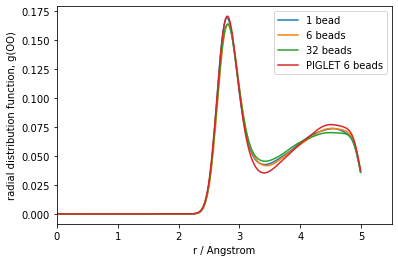

In [23]:
######################### Calculating the g(OH) radial distribution function ####################################
beads = np.array(['1','6','32'])
nbins = 250
rdf = np.zeros((len(beads),nbins))
dist = np.zeros((len(beads),nbins))
count = 0
fig,ax = plt.subplots()

for i in beads:
    infile = 'ex-1/base_p-'+i+'.OO.rdf.dat'
    rdf[count,:] = np.genfromtxt(infile,usecols = 1) 
    dist[count,:] = np.genfromtxt(infile,usecols = 0)
    plt.plot(dist[count,:],rdf[count,:],label=str(int(i))+' beads' if int(i)>1 else str(int(i))+' bead')
    count +=1

rdf = np.zeros((nbins))
dist = np.zeros((nbins))
os.chdir('ex-2')
RDF('piglet_p-6', "pdb", 'O', 'H', 300, 0., 3., 0.1)
os.chdir('../')

infile = 'ex-2/piglet_p-6.OO.rdf.dat'
rdf[:] = np.genfromtxt(infile,usecols = 1) 
dist[:] = np.genfromtxt(infile,usecols = 0)
plt.plot(dist[:],rdf[:],label='PIGLET 6 beads')

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads 
plt.xlabel('r / Angstrom')
plt.ylabel('radial distribution function, g(OO)')
ax.set_xlim([0.,5.5])
plt.legend(loc=1)
plt.show()

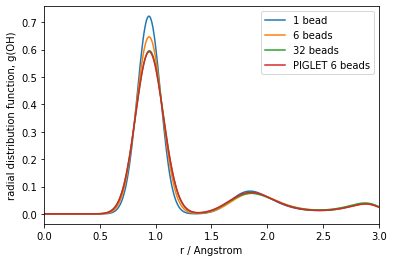

In [25]:
######################### Calculating the g(OO) radial distribution function ####################################
beads = np.array(['1','6','32'])
nbins = 300
rdf = np.zeros((len(beads),nbins))
dist = np.zeros((len(beads),nbins))
count = 0
fig,ax = plt.subplots()

for i in beads:
    infile = 'ex-1/base_p-'+i+'.OH.rdf.dat'
    rdf[count,:] = np.genfromtxt(infile,usecols = 1) 
    dist[count,:] = np.genfromtxt(infile,usecols = 0)
    plt.plot(dist[count,:],rdf[count,:],label=str(int(i))+' beads' if int(i)>1 else str(int(i))+' bead')
    count +=1


rdf = np.zeros((nbins))
dist = np.zeros((nbins))
os.chdir('ex-2')
RDF('piglet_p-6', "pdb", 'O', 'O', 250, 0., 5., 0.1)
os.chdir('../')

infile = 'ex-2/piglet_p-6.OH.rdf.dat'
rdf[:] = np.genfromtxt(infile,usecols = 1) 
dist[:] = np.genfromtxt(infile,usecols = 0)
plt.plot(dist[:],rdf[:],label='PIGLET 6 beads')

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads 
plt.xlabel('r / Angstrom')
plt.ylabel('radial distribution function, g(OH)')
ax.set_xlim([0.,3.])
plt.legend(loc = 1)
plt.show()

<h2> Exercise 3 - Variable-cell sampling </h2>
Let’s now try to use the constant-pressure sampling features of i-PI to perform (colored-noise) path integral dynamics of water at high temperature and GPa pressure. Note that the most interesting physics in these conditions relates to high rates of self-ionization, that is observed in classical ab initio simulations [4], and is much enhanced by quantum effects [5]. Unfortunately, in this tutorial we can only use a non-dissociable forcefield and so we will not be able to explore this aspect.

1. A working example is provided in the input file `ex-3/npt.xml`, but don’t run it just yet. What thermostat is being used? How many beads? Although one may think that at such a high temperature quantum effects will be mild, it is a good idea to use a PIGLET thermostat just to be sure. Generate input parameters from http://gle4md.org/index.html?page=matrix, adapting them to the thermodynamic conditions considered here, substitute the ```<thermostat>``` field and launch your simulation. Hints: Note that the barostat
(a kind of a Langevin piston [6], adapted to PIMD [5]) contains a separate ```<thermostat>```. You should not touch this, or at least make sure you keep a classical thermostat, since the degrees of freedom of the cell cannot be thermostatted with a quantum GLE (why? think of how the GLE infers the fluctuations from the time scale of oscillations, and how the time scale of the cell dynamics is an arbitrary parameter).

2. Analyze the run by observing the convergence of the cell volume to the equilibrium value, and check that the pressure does fluctuate around the target value. You can also visualize the variable-cell trajectory in VMD. Hints: You can visualize the simulation box with the TCL command 
     `vmd > pbc box`


=================================== volume ============================================
================================== 6 beads =============================================
 mean = 4.0415e+03  |  variance: = 1.0781e+04  |  st.dev. = 1.0383e+02
<tau> = 4.9521e+01  |    <tau^2> = 2.6265e+01  |  error = 1.0355e+01

================================= pressure ============================================


/home/eszter/I-PY/pimd-tutorial/exercises/day-2/autocorr.py:28: RuntimeWarning: invalid value encountered in sqrt
  error = std/np.sqrt(len(data)*dt*0.5/tau)


================================== 6 beads =============================================
 mean = 9.9976e+00  |  variance: = 3.1294e+00  |  st.dev. = 1.7690e+00
<tau> = -8.6551e-02  |    <tau^2> = 2.2963e+00  |  error =      nan



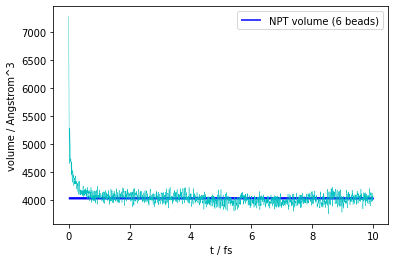

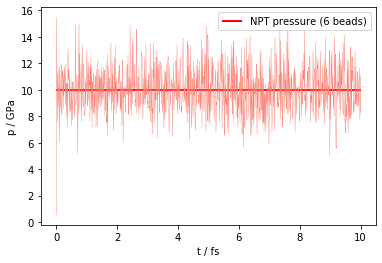

In [26]:
print('=================================== volume ============================================')
volMean,volError = autoCorr('ex-3/npt_p-6.out', nbead=6, columns=[6], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=8)
print('================================= pressure ============================================')
preMean,preError = autoCorr('ex-3/npt_p-6.out', nbead=6, columns=[7], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=8)

data = np.genfromtxt('ex-3/npt_p-6.out',usecols=[1,6,7])

plt.plot(data[:,0],data[:,1], 'c-', linewidth=0.4)
plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=volMean,color='b', label='NPT volume (6 beads)')
plt.fill_between(data[:,0], volMean-volError, volMean+volError, color='b', alpha=0.8 )
plt.xlabel('t / fs')
plt.ylabel('volume / Angstrom^3')
plt.legend(loc=1)
plt.show()

plt.plot(data[::10,0],data[::10,2], '-', color='salmon', linewidth=0.4)
plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=preMean,color='r', label='NPT pressure (6 beads)', linewidth=2.)
plt.fill_between(data[:,0], preMean-preError, preMean+preError, color='r', alpha=0.2 )
plt.xlabel('t / fs')
plt.ylabel('p / GPa')
plt.legend(loc=1)
plt.show()

#plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=trad_kin_mean,color='y', label='expected volume', linewidth=2.)
#plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=trad_pot_mean,color='g', label='expected pressure (10 GPa)', linewidth=2.)


<h2>Exercise 4 - Doing PIMD Like a Pro</h2>

As a final example (in folder `ex-4/`) we will combine all the bits and pieces, performing a simulation of ice at 100K, combining two different techniques to speed up the calculation. We will use a fourth-order Suzuki-Chin factorization of the Boltzmann operator [7, 8], combined with a finite-difference integrator [9]. Ring-polymer contraction [10] can also be used, that speeds up simulations by evaluating long-range interactions on a reduced number of beads. We will not cover here the theory behind these techniques, so if you are not familiar with it, you are encouraged to read up the relevant literature before embarking in this exercise. 

Hints: These start to be serious simulations, and it will not be possible to converge them at any decent level with a few minutes on a laptop. You can let them run overnight and/or run them on a more powerful computer if you want to familiarize yourself with the convergence behavior of these accelerated PI methods.

1. Start by running the Suzuki-Chin simulation, that is 
	
    `$ i-pi highorder.xml &> log.ipi &` <br>
	`$ lmp_serial < in.ice &> log.lammps &`
    
    
While the simulation runs, look at the input file. You’ll notice that we are outputting four more properties: `kinetic_opsc`, `kinetic_tdsc`, `potential_opsc`, `potential_tdsc` . These are the "thermodynamic" and "operator" versions of the Suzuki-Chin estimators for kinetic and potential energy. Note that – contrary to the Trotter case – the thermodynamic estimators are well-behaved when the number of beads is increased. You should see that after a few steps both the `Td` and the `Op` versions converge to very similar values, and that they are both significantly different from the conventional estimators (that do not correspond to any physical observable when sampling a fourth-order Hamiltonian, and are output only for didactic purposes). 

Hints: Remember, when you compute averages, that you’ll have to discard the (rather long) equilibration part, and that you should use the columns that correspond to the S-C estimators.
	


In [ ]:
print('================================ kinetic op ===========================================')
kin_op_Mean,kin_op_Error = autoCorr('ex-4/ice-sc.out', nbead=6, columns=[6], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=10)
print('================================ kinetic td ===========================================')
kin_td_Mean,kin_td_Error = autoCorr('ex-3/ice-sc.out', nbead=6, columns=[7], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=10)
print('=============================== potential op ==========================================')
kin_op_Mean,kin_op_Error = autoCorr('ex-4/ice-sc.out', nbead=6, columns=[8], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=10)
print('=============================== potential td ==========================================')
kin_td_Mean,kin_td_Error = autoCorr('ex-3/ice-sc.out', nbead=6, columns=[9], mlag=100, 
                      nequi=43, dt=1.0, verbosity = 1, ncol=10)


data = np.genfromtxt('ex-3/npt_p-6.out',usecols=[1,6,7,8,9])

plt.plot(data[:,0],data[:,1], 'c-', linewidth=0.4)
plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=volMean,color='b', label='NPT volume (6 beads)')
plt.fill_between(data[:,0], volMean-volError, volMean+volError, color='b', alpha=0.8 )
plt.xlabel('t / fs')
plt.ylabel('volume / Angstrom^3')
plt.legend(loc=1)
plt.show()

plt.plot(data[::10,0],data[::10,2], '-', color='salmon', linewidth=0.4)
plt.hlines(xmin=data[0,0], xmax=data[-1,0], y=preMean,color='r', label='NPT pressure (6 beads)', linewidth=2.)
plt.fill_between(data[:,0], preMean-preError, preMean+preError, color='r', alpha=0.2 )
plt.xlabel('t / fs')
plt.ylabel('p / GPa')
plt.legend(loc=1)
plt.show()

2. Compute radial distribution functions. When inspecting trajectories, remember that in SC path integrals you can evaluate structural observables by analyzing the even beads from the trajectory, and ignoring the odd ones.
You can try to compute RDFs for even and odd beads separately, and verify that the two subsets sample different ensembles.


In [ ]:
## using your experience before set up the correct commands and plot your results in this cell

nbins = 300
rdf = np.zeros((nbins))
dist = np.zeros((nbins))
fig,ax = plt.subplots()


# use only the even beads by renaming the odd files in your terminal!!  
infile = 'ex-4/ice-sc_even'+i+'.OH.rdf.dat'
rdf[count,:] = np.genfromtxt(infile,usecols = 1) 
dist[count,:] = np.genfromtxt(infile,usecols = 0)
plt.plot(dist[:],rdf[:],label='Suzuki-Chin even beads')

# use only the odd beads by renaming the even files in your terminal!! 
infile = 'ex-4/ice-sc_odd'+i+'.OH.rdf.dat'
rdf[:] = np.genfromtxt(infile,usecols = 1) 
dist[:] = np.genfromtxt(infile,usecols = 0)
plt.plot(dist[:],rdf[:],label='Suzuki-Chin odd beads')

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads 
plt.xlabel('r / Angstrom')
plt.ylabel('radial distribution function, g(OH)')
ax.set_xlim([0.,3.])
plt.legend(loc = 1)
plt.show()

3. Finally, try to run the input file that also uses RPC

	`$ i-pi ultimate.xml &> log.ipi &` <br>
	`$ lmp_serial < in.ice_long &> log.lammps &` <br>
	`$ lmp_serial < in.ice_short &> log.lammps &` <br>

    Try to follow the complex simulation set up. If you are familiar with the structure of LAMMPS input files, you’ll notice that in.ice_long computes only Lennard-Jones and Coulomb terms, while bonded terms contain dummy values. Conversely, in.ice_short only computes the bonded (stretch and bend) interactions. These two LAMMPS instances connect to two separate ```<ffsocket>``` objects, that provide evaluators for the short and long-range components of the force. Now, within the description of the ```<system>```, you will find the setup of the physical interactions, as they will be used by the integrator:

	```<forces>``` <br>
    ```    <force forcefield="lammps.long" nbeads="8"> </force>``` <br>
    ```    <force forcefield="lammps.short" > </force>``` <br>
	```</forces>```

    This specifies that long-range forces should be computed on a contracted ring polymer with only eight beads. Conversely, the short-range component should be computed on the default (total) number of beads, as specified in the ```<initialize>``` section. Now compare the results with what you obtained with the `highorder.xml` input. You should observe only small differences, although considerably fewer long-range force evaluations have been used. 
    Hints: For a cheap potential as the one we consider here, communication overhead is dominant, and so the speed-up will not be very noticeable. Nevertheless, this strategy can be very advantageous when the long-range part of the interaction is time-consuming, such as in an ab initio simulation.

<h2>References</h2>
[1] Scott Habershon, Thomas E Markland, and David E Manolopoulos. Competing quantum effects in the dynamics of a flexible water model. J. Chem. Phys., 131:24501, <strong>2009</strong>.

[2] Michele Ceriotti, David E Manolopoulos, and Michele Parrinello. Accelerating the convergence of path integral dynamics with a generalized Langevin equation. J. Chem. Phys., 134:84104, <strong>2011</strong>.

[3] Michele Ceriotti and David E Manolopoulos. Efficient First-Principles Calculation of the Quantum Kinetic Energy and Momentum Distribution of Nuclei. Phys. Rev. Lett., 109:100604, <strong>2012</strong>.

[4] Eric Schwegler, Giulia Galli, François Gygi, and Randolph Hood. Dissociation of Water under Pressure. Phys. Rev. Lett., 87:265501, <strong>2001</strong>.

[5] Michele Ceriotti, Joshua More, and David E. Manolopoulos. i-PI: A Python interface for ab initio path integral molecular dynamics simulations. Comp. Phys. Comm., 185:1019–1026, <strong>2014</strong>.

[6] Giovanni Bussi, Tatyana Zykova-Timan, and Michele Parrinello. Isothermal-isobaric molecular dynamics using stochastic velocity rescaling. 130:74101, <strong>2009</strong>.

[7] M Suzuki. Hybrid exponential product formulas for unbounded operators with possible applications to Monte Carlo simulations. Phys. Lett. A, 201:425–428, <strong>1995</strong>.

[8] Siu A. Chin. Symplectic integrators from composite operator factorizations. Phys. Lett. A, 226:344–348, <strong>1997</strong>.

[9] V. Kapil, J. Behler, and M. Ceriotti. High order path integrals made easy: A precise assessment of nuclear quantum effects in liquid water and its isotopomers.

[10] Thomas E Markland and David E Manolopoulos. An efficient ring polymer contraction scheme for imaginary time path integral simulations. J. Chem. Phys., 129:024105, <strong> 2008</strong>.

In [5]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    np.hanning, np.hamming, np.bartlett, np.blackman, np.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is not one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y